In [5]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Create the environment
def create_env():
    return gym.make('FrozenLake-v1', is_slippery=False)  # or True, depending on your use case

# Initialize Q-table
def initialize_q_table(env):
    number_of_states = env.observation_space.n #16, campo 4x4
    number_of_actions = env.action_space.n #4, su,giu,dx,sx
    return np.zeros((number_of_states, number_of_actions))

# Decay function for epsilon
def decay_function(episode, total_train_episodes, min_epsilon, max_epsilon, current_epsilon, decay_type):
    if decay_type == 'linear':
        tmp = current_epsilon = current_epsilon - (current_epsilon / total_train_episodes)
        return max(min_epsilon,tmp)
    elif decay_type == 'log':
        return max(min_epsilon, min(1.0, 1.0 - np.log10((episode + 1) / (total_train_episodes * 0.1))))


def exploratory_policy(env):
   return np.random.choice(env.action_space.n)


# Choose action based on epsilon-greedy policy (Behavior Policy)
def choose_action(q_table, state, epsilon, env):
    if np.random.random() <= epsilon:
        return env.action_space.sample()  # Exploration
    else:
        return np.argmax(q_table[state])  # Exploitation


def generate_episode(epsilon, q_table, env, max_env_steps):
    state = env.reset()
    total_reward = 0
    done = False
    trajectory = []
    
    for step in range(max_env_steps):
        if isinstance(state, tuple):
            state = state[0]

        action = exploratory_policy(env)
        new_state, reward, done, info, _ = env.step(action)
        trajectory.append((state, action, reward))
        state = new_state
        total_reward += reward
        if done:
            break
    
    return trajectory, total_reward



# Calculate P(x) for epsilon-greedy policy
def epsilon_greedy_prob(action, state, q_table, epsilon, env):
    number_of_actions = env.action_space.n
    optimal_action = np.argmax(q_table[state])
    if action == optimal_action:
        return epsilon / number_of_actions + (1.0 - epsilon)
    else:
        return epsilon / number_of_actions

# Every-Visit Monte Carlo con importance sampling
def every_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon, current_epsilon, decay_type):
    env.reset()
    q_table = initialize_q_table(env)
    history = np.zeros((total_train_episodes, *q_table.shape))
    epsilons= np.zeros(total_train_episodes)
    visits_counter = np.zeros_like(q_table)
    env.reset()
    max_env_steps = env.spec.max_episode_steps
    
    epsilon = current_epsilon
    for episode in range(total_train_episodes):
        env.reset()
        epsilon = decay_function(episode, total_train_episodes, min_epsilon, max_epsilon, epsilon, decay_type)
        trajectory, _ = generate_episode(epsilon, q_table, env, max_env_steps)
        g_mu = 0
        g_pi=1
        w = 1  # Peso iniziale
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            #print(state, action, reward)
            g_mu = gamma * g_mu + reward
            
            # Calculate the importance sampling ratio
            
            mu_x = 1.0 / env.action_space.n  # Random policy probability
            pi_x = epsilon_greedy_prob(action, state, q_table, epsilon, env)  # Epsilon-greedy probability
            
            w = pi_x / mu_x  # Update weight
            g_pi *= w * g_mu  # Calculate G^\pi_t
           
            # Q-update using the formula
            visits_counter[state, action] += w
            q_table[state, action] += (g_pi - q_table[state, action])/visits_counter[state, action] 

        history[episode] = q_table
        epsilons[episode] = epsilon
        #print(q_table)
        
        #print(f"Episode {episode}, epsilon {epsilon:.4f}")
    
    return q_table, history, epsilons


# First-Visit Monte Carlo con importance sampling
def first_visit_monte_carlo(env, total_train_episodes, gamma, max_epsilon, min_epsilon, current_epsilon, decay_type):
    env.reset()
    q_table = initialize_q_table(env)
    visits_counter = np.zeros_like(q_table)
    history = np.zeros((total_train_episodes, *q_table.shape))
    epsilons= np.zeros(total_train_episodes)
    max_env_steps = env.spec.max_episode_steps

    epsilon = current_epsilon
    for episode in range(total_train_episodes):
        env.reset()
        epsilon = decay_function(episode, total_train_episodes, min_epsilon, max_epsilon, epsilon, decay_type)  
        #print(f"Episode {episode}, epsilon {epsilon:.4f}")
        trajectory, _ = generate_episode(epsilon, q_table, env, max_env_steps)
        g_mu = 0
        g_pi=1
        w=1  # Peso iniziale
        visited_state_actions = set()
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            #print(state, action, reward)
            g_mu = gamma * g_mu + reward
            
            
           # Controlla se [state, action] non è stato visitato prima in questa traiettoria
            if (state, action) not in visited_state_actions:
                # Aggiungi [state, action] al set dei visitati
                visited_state_actions.add((state, action))
                # Calculate the importance sampling ratiopr
                mu_x = 1.0 / env.action_space.n  # Random policy probability
                pi_x = epsilon_greedy_prob(action, state, q_table, epsilon, env)  # Epsilon-greedy probability
                
                w = pi_x / mu_x  # Update weight
                
                g_pi *= w * g_mu  # Calculate G^\pi_t
                #print(g_mu)
                
                # Q-update using the formula
                visits_counter[state, action] += w
                q_table[state, action] += (g_pi - q_table[state, action])/ visits_counter[state, action] 
               
        
        history[episode] = q_table
        epsilons[episode] = epsilon
        #print(q_table)
    
    return q_table, history, epsilons






In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os


def save_data(base_filename, q_table, history, epsilons):
    filenames = [f'OFF/models/{base_filename}_tables.npy', 
                 f'OFF/models/{base_filename}_Q.npy', 
                 f'OFF/models/{base_filename}_epsilons.npy']
    
    # Remove existing files if they exist
    for filename in filenames:
        if os.path.exists(filename):
            os.remove(filename)
    
    # Save the new data
    np.save(f'OFF/models/{base_filename}_tables.npy', history)
    np.save(f'OFF/models/{base_filename}_Q.npy', q_table)
    np.save(f'OFF/models/{base_filename}_epsilons.npy', epsilons)


# Main code
if __name__ == "__main__":
    n_times = 1  # Number of training sessions
    gamma = 0.99
    max_epsilon = 1.0
    min_epsilon = 0.01
    current_epsilon = 1.0

    env = create_env()

    for number in range(n_times):
        print(f"\n ********** First-Visit Monte Carlo Training number {number} **********")
        
        # First-Visit Monte Carlo with log decay
        q_table1, history1, epsilons1 = first_visit_monte_carlo(env,5000, gamma, max_epsilon, min_epsilon, current_epsilon, "log")
        save_data('FV_MC_log', q_table1, history1, epsilons1)
        
        # First-Visit Monte Carlo with linear decay
        q_table3, history3, epsilons3 = first_visit_monte_carlo(env, 5000, gamma, max_epsilon, min_epsilon, current_epsilon, "linear")
        save_data('FV_MC_linear', q_table3, history3, epsilons3)

    for number in range(n_times):
        print(f"\n ********** Every-Visit Monte Carlo Training number {number} **********")
        
        # Every-Visit Monte Carlo with log decay
        q_table2, history2, epsilons2 = every_visit_monte_carlo(env, 5000, gamma, max_epsilon, min_epsilon, current_epsilon, "log")
        save_data('EV_MC_log', q_table2, history2, epsilons2)
        
        # Every-Visit Monte Carlo with linear decay
        q_table4, history4, epsilons4 = every_visit_monte_carlo(env, 5000, gamma, max_epsilon, min_epsilon, current_epsilon, "linear")
        save_data('EV_MC_linear', q_table4, history4, epsilons4)

  



 ********** First-Visit Monte Carlo Training number 0 **********

 ********** Every-Visit Monte Carlo Training number 0 **********


# Policy Plot

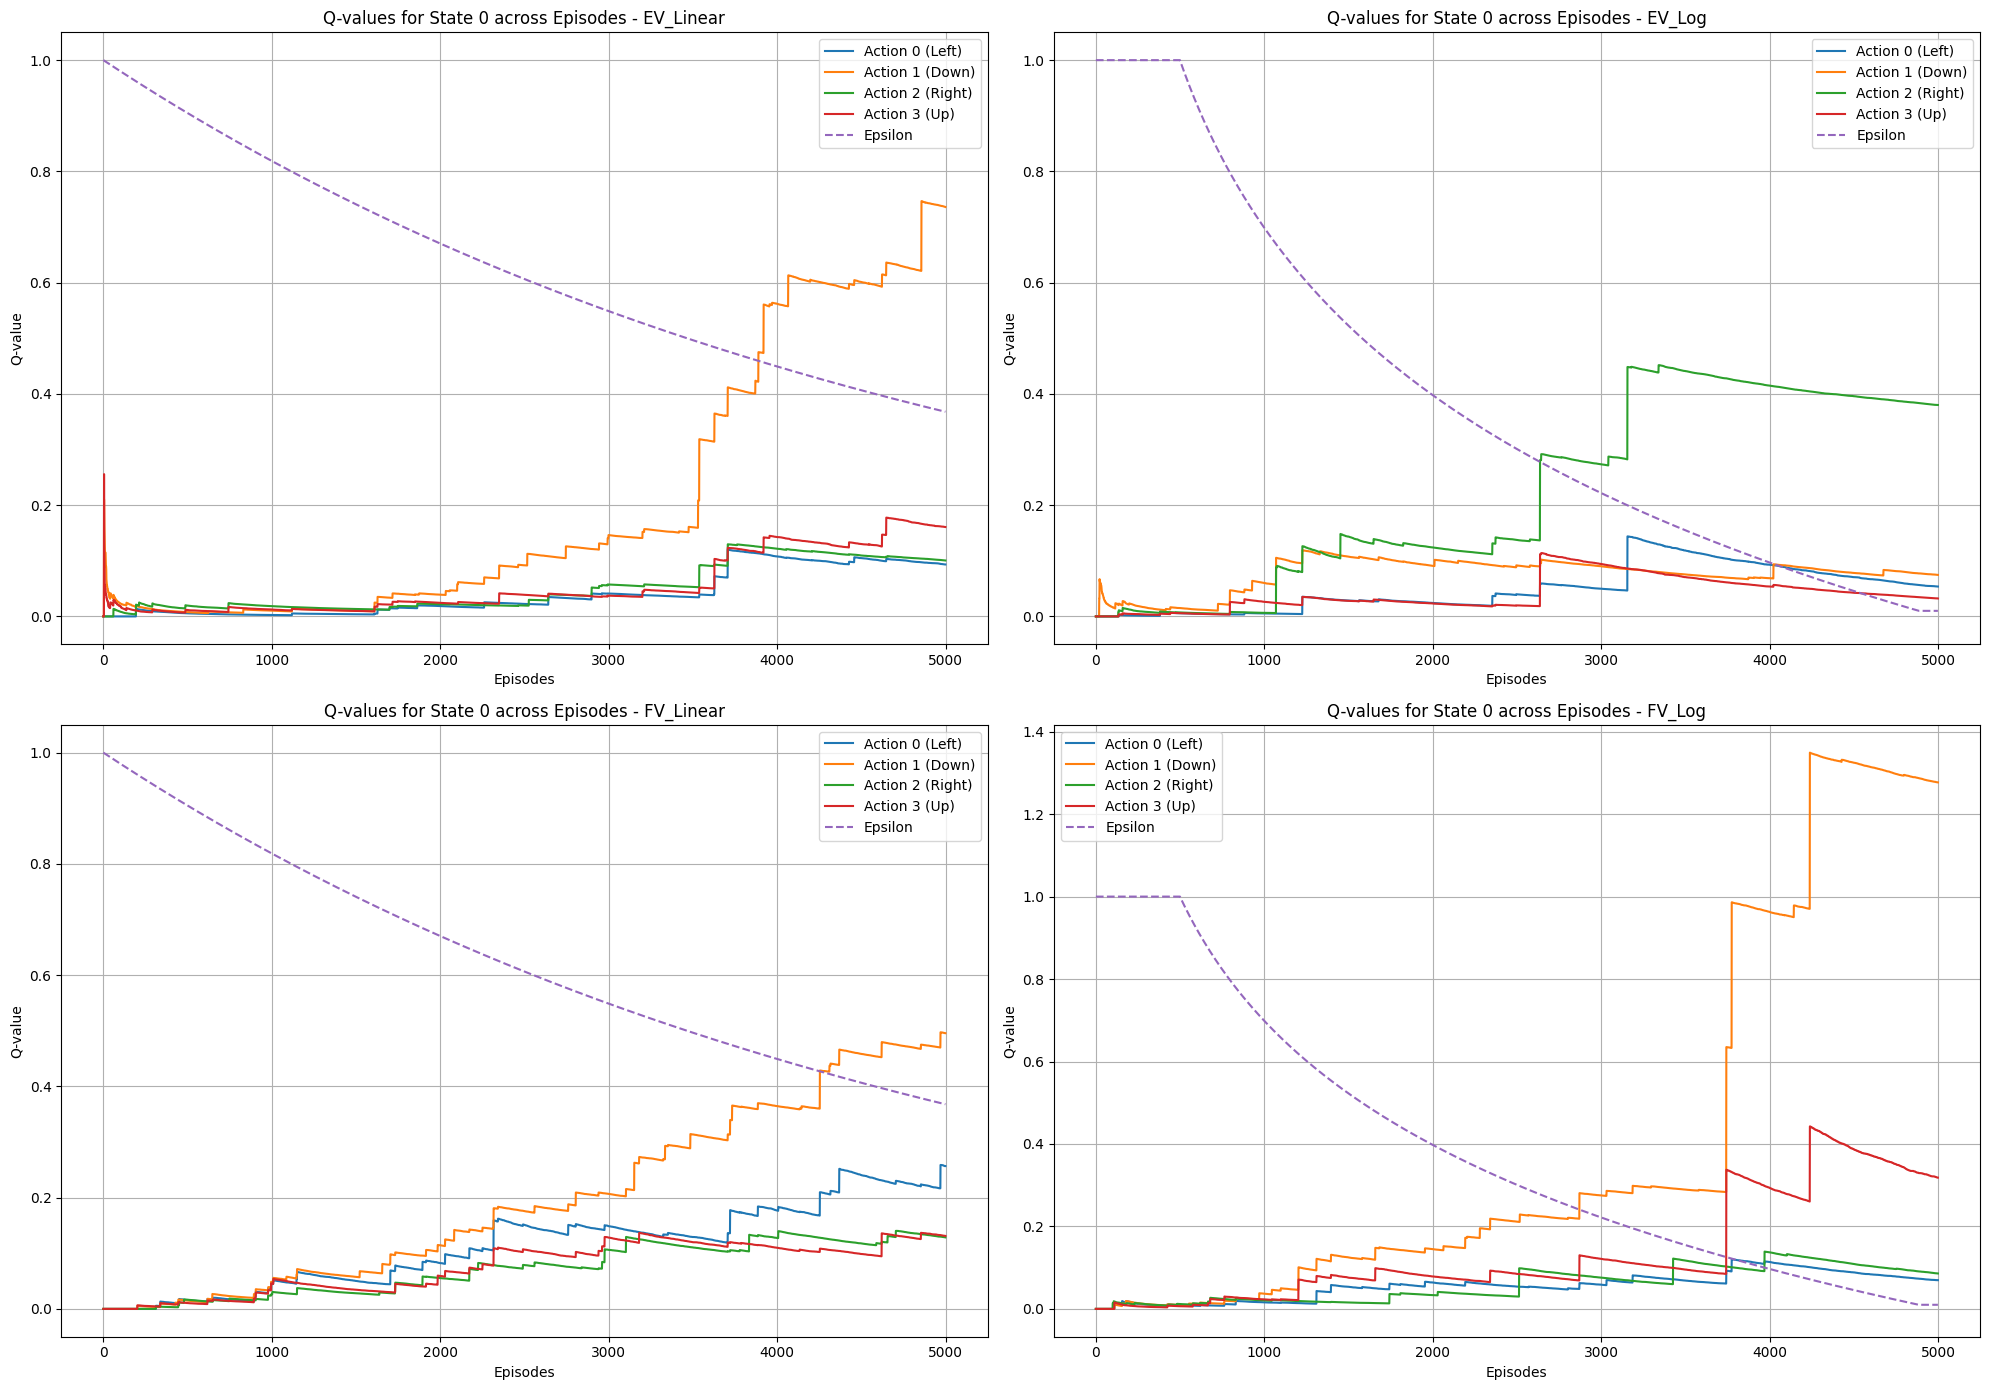

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Load data for different decay functions and learning rates
# Replace with actual file paths and names
data_files = {
    'EV_Linear': {
        'q_values': 'OFF/models/EV_MC_linear_tables.npy',
        'epsilons': 'OFF/models/EV_MC_linear_epsilons.npy'
    },
    'EV_Log': {
        'q_values': 'OFF/models/EV_MC_log_tables.npy',
        'epsilons': 'OFF/models/EV_MC_log_epsilons.npy'
    },
    'FV_Linear': {
        'q_values': 'OFF/models/FV_MC_linear_tables.npy',
        'epsilons': 'OFF/models/FV_MC_linear_epsilons.npy'
    },
    'FV_Log': {
        'q_values': 'OFF/models/FV_MC_log_tables.npy',
        'epsilons': 'OFF/models/FV_MC_log_epsilons.npy'
    }
}

# Select the state you want to plot
state = 0 # Example: state 0

# Number of actions (assuming 4 actions as in FrozenLake)
num_actions = 4
action_labels = {
    0: 'Left',
    1: 'Down',
    2: 'Right',
    3: 'Up'
}

# Create a single figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Loop through each decay function and plot on a separate subplot
for ax, (label, files) in zip(axes, data_files.items()):
    history = np.load(files['q_values'])
    epsilons = np.load(files['epsilons'])

    # Plot Q-values for each action
    for action in range(num_actions):
        q_values = history[:, state, action]
        ax.plot(q_values, label=f'Action {action} ({action_labels[action]})')

    # Plot epsilon values
    ax.plot(epsilons, label='Epsilon', linestyle='--')

    # Customize the subplot
    ax.set_title(f"Q-values for State {state} across Episodes - {label}")
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Q-value')
    ax.legend()
    ax.grid(True)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(f'OFF/imgs/Qvar_state{state}.png')
plt.show()


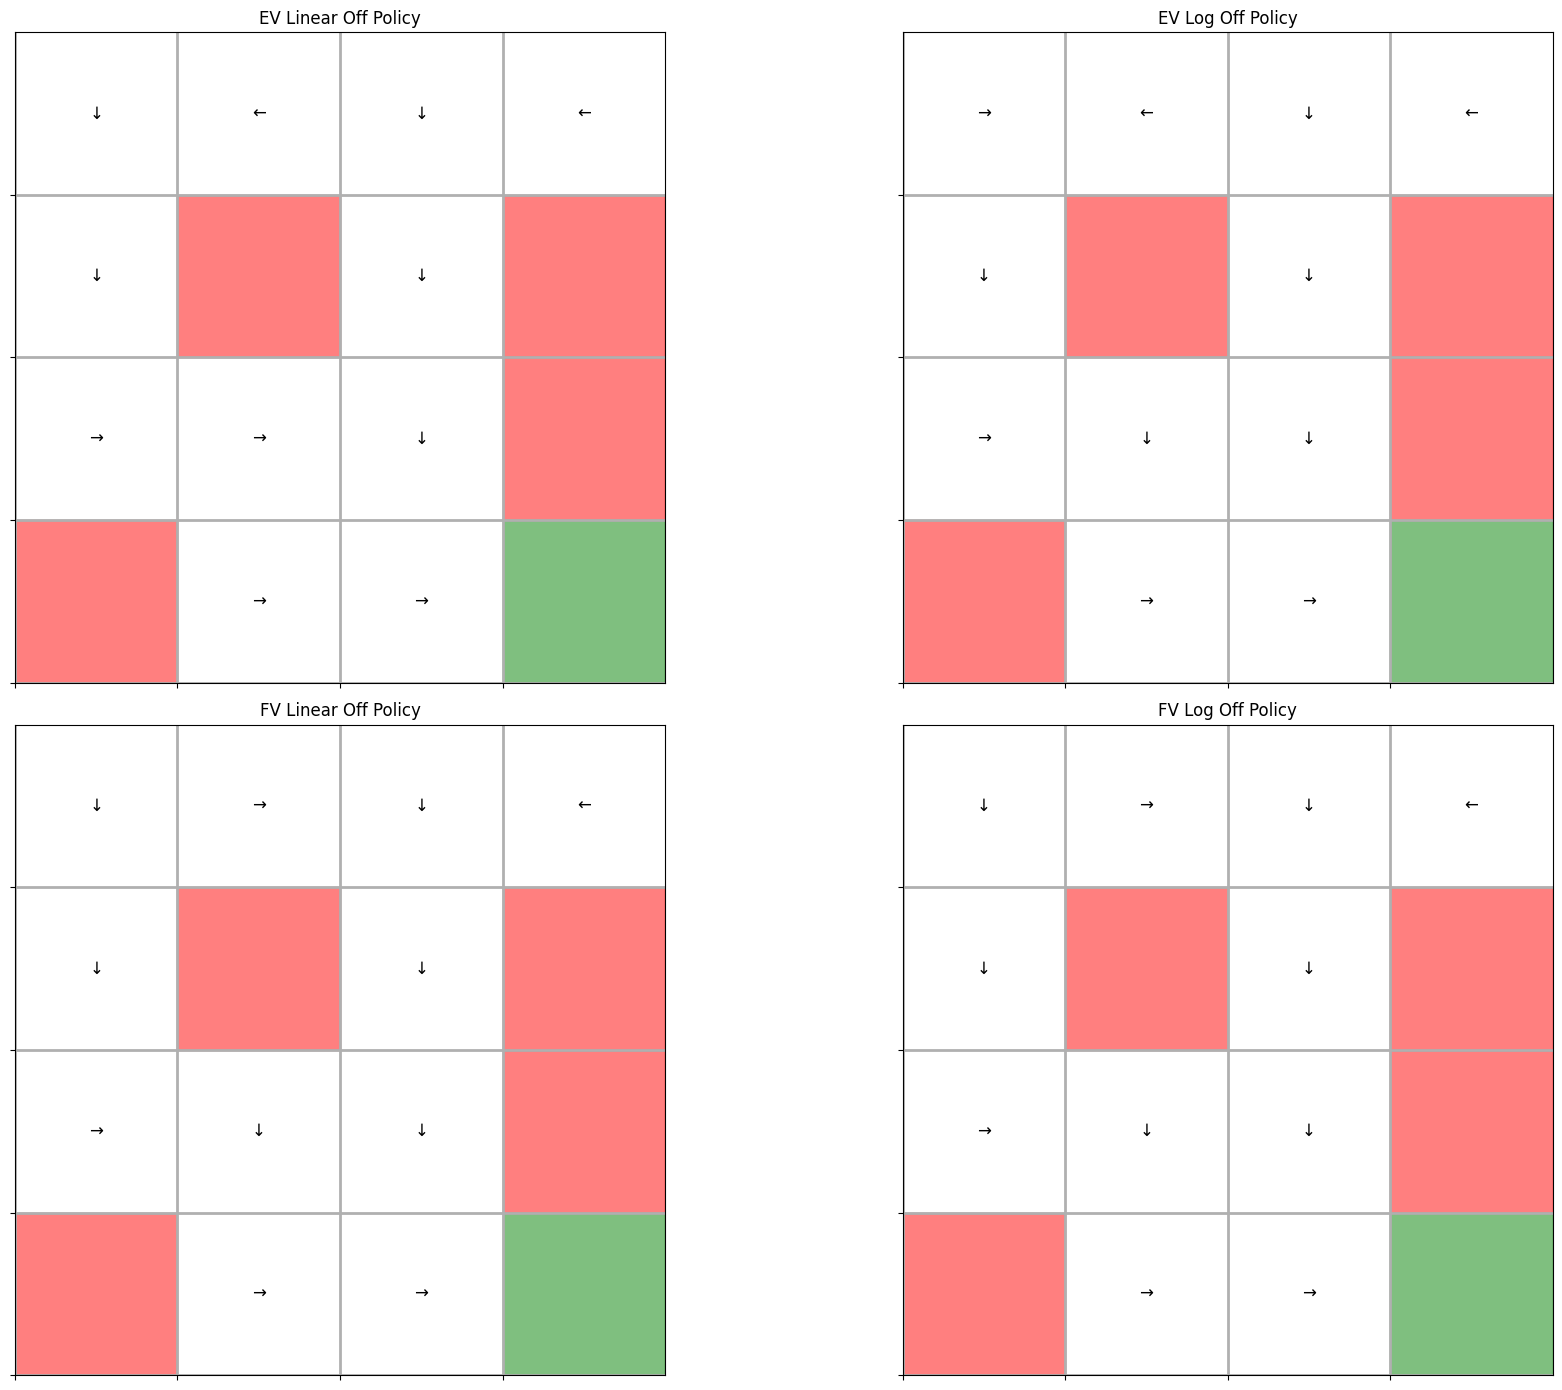

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_policy(ax, q_table, grid_size=(4, 4), title='Policy', special_cells={}):
    """
    Plots the policy learned by the Q-table on a grid, with special colored cells.

    Parameters:
        ax (matplotlib.axes.Axes): The axes on which to plot the policy.
        q_table (numpy.ndarray): The Q-table from which to derive the policy.
        grid_size (tuple): The size of the grid representing the environment (default is (4, 4)).
        special_cells (dict): Dictionary mapping cell indices to colors (e.g., {5: 'red', 15: 'green'}).
    """
    # Define direction labels
    direction_labels = {
        0: '←',  # left
        1: '↓',  # down
        2: '→',  # right
        3: '↑'   # up
    }

    policy = np.argmax(q_table, axis=1).reshape(grid_size)

    # Set up the grid
    ax.set_xticks(np.arange(grid_size[1]))
    ax.set_yticks(np.arange(grid_size[0]))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    # Create grid
    ax.grid(which='both', linestyle='-', linewidth=2)
    
    # Plot direction labels and special cell colors
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            cell_idx = i * grid_size[1] + j
            action = policy[i, j]

            if cell_idx in special_cells:
                # Add a colored rectangle for special cells
                rect = patches.Rectangle((j, grid_size[0] - i - 1), 1, 1, color=special_cells[cell_idx], alpha=0.5)
                ax.add_patch(rect)
            else:
                direction = direction_labels[action]
                ax.text(j + 0.5, grid_size[0] - i - 0.5, direction,
                        ha='center', va='center', fontsize=12, color='black')

    # Set the aspect of the plot to equal
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim(0, grid_size[1])
    ax.set_ylim(0, grid_size[0])

# Create a single figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()  # Flatten the array of axes for easy iteration

# Load Q-tables
FV_q_table_lin = np.load('OFF/models/FV_MC_linear_Q.npy', allow_pickle=True)
EV_q_table_lin = np.load('OFF/models/EV_MC_linear_Q.npy', allow_pickle=True)
FV_q_table_log = np.load('OFF/models/FV_MC_log_Q.npy', allow_pickle=True)
EV_q_table_log = np.load('OFF/models/EV_MC_log_Q.npy', allow_pickle=True)

# Define titles and Q-tables
data = [
    (EV_q_table_lin, 'EV Linear Off Policy'),
    (EV_q_table_log, 'EV Log Off Policy'),
    (FV_q_table_lin, 'FV Linear Off Policy'),
    (FV_q_table_log, 'FV Log Off Policy')
]

# Define the special cells to be colored
special_cells = {
    5: 'red',
    7: 'red',
    11: 'red',
    12: 'red',
    15: 'green'
}

# Plot each policy in a separate subplot
for ax, (q_table, title) in zip(axes, data):
    plot_policy(ax, q_table, title=title, special_cells=special_cells)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('OFF/imgs/policy_plots_with_colors.png')
plt.show()
